#   Notebook that Explores and Clusters the Neighborhood in New South Wales, Australia including neighbourhoods impacted the most by the 2019-20 Australian bushfire season 
#### Image taken from Vox

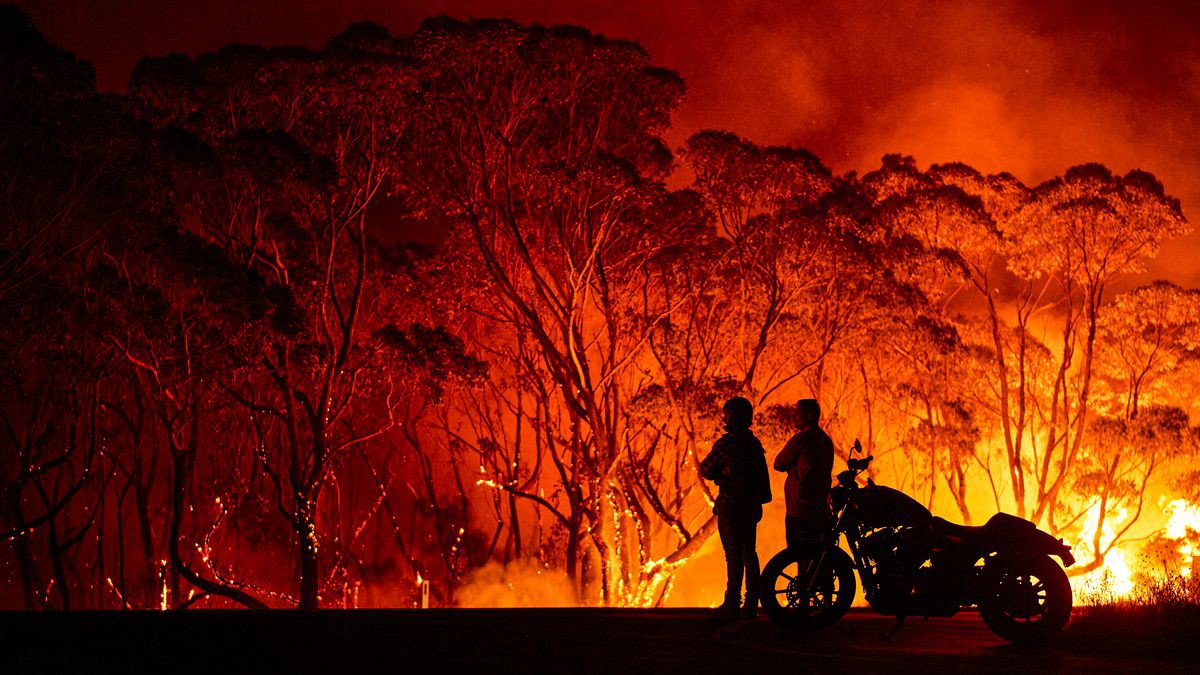

https://en.wikipedia.org/wiki/2019%E2%80%9320_Australian_bushfire_season#Sydney

##### Importing all the needed libaries first

In [13]:
# importing the essential libraries
import pandas as pd
from bs4 import BeautifulSoup
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [14]:
# Source of the "free and close to 100% accurate" raw csv data of all the states,post code, neighbourhoods in Australia
# Australian post now charges for this same data!
# https://www.matthewproctor.com/australian_postcodes
#loading the raw data as *.csv 
nsw_raw =pd.read_csv("C:/Users/Eni/OneDrive/Data Analysis Challenge/australian_postcodes_NSW_Filter_Raw.csv")
nsw_copy =nsw_raw.copy()
nsw_copy.head(5)

,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name
0,1001,SYDNEY,NSW,151.268071,-33.794883,EAST SUBS MC,LVR,Updated 25-Mar-2020 SA3,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South
1,1002,SYDNEY,NSW,151.268071,-33.794883,EAST SUBS MC,LVR,Updated 25-Mar-2020 SA3,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South
2,1003,SYDNEY,NSW,151.268071,-33.794883,EAST SUBS MC,LVR,Updated 25-Mar-2020 SA3,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South
3,1004,SYDNEY,NSW,151.268071,-33.794883,EAST SUBS MC,LVR,Updated 25-Mar-2020 SA3,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South
4,1005,SYDNEY,NSW,151.268071,-33.794883,GPO BOX CENTRE,LVR,Updated 25-Mar-2020 SA3,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South


In [3]:
#cleaning up some columns as they're only relevant to AustPost.
nsw_copy.drop(["state","dc","type","status"],axis=1,inplace=True)
nsw_copy.tail(5)

,postcode,locality,long,lat,sa3,sa3name,sa4,sa4name
5531,4380,MINGOOLA,151.529213,-28.940993,30703.0,Granite Belt,307.0,Darling Downs - Maranoa
5532,4380,RUBY CREEK,152.018346,-28.625911,30703.0,Granite Belt,307.0,Darling Downs - Maranoa
5533,4380,UNDERCLIFFE,152.182263,-28.622551,30703.0,Granite Belt,307.0,Darling Downs - Maranoa
5534,4383,JENNINGS,151.969412,-28.940512,30703.0,Granite Belt,307.0,Darling Downs - Maranoa
5535,4385,CAMP CREEK,150.880359,-28.755116,30701.0,Darling Downs (West) - Maranoa,307.0,Darling Downs - Maranoa


In [12]:
## As there are over 5000 neighbourhoods we will group them to the next manageable records for our client
## we will also take a peek at what our grouped 102 suburbs looks like
nsw_neigh= nsw_copy.groupby('sa3',as_index=False).agg({'locality':'first','long':'first','lat':'first','sa3name':'first','sa4':'first','sa4name':'first'})
#nsw_copy
print(nsw_neigh.shape)
nsw_neigh.head()


(102, 7)


,sa3,locality,long,lat,sa3name,sa4,sa4name
0,10101.0,BINALONG,148.555243,-34.711018,Goulburn - Yass,101.0,Capital Region
1,10102.0,BELLMOUNT FOREST,149.286631,-34.764484,Queanbeyan,101.0,Capital Region
2,10103.0,THREDBO,148.301005,-36.506610,Snowy Mountains,101.0,Capital Region
3,10104.0,BERGALIA,149.912199,-35.939649,South Coast,101.0,Capital Region
4,10201.0,AVOCA BEACH,151.401999,-33.482209,Gosford,102.0,Central Coast


In [4]:
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
import matplotlib
import descartes


In [2]:
## reading in the shapefile from ABS for whole of Australia
AustSD11_gdf = gpd.read_file("C:/Users/Eni/OneDrive/Data Analysis Challenge/SD11aAust.shp")
AustSD11_gdf.head(12)
## creating a new dataframe that will filtered to NSW
scode1 = AustSD11_gdf[['STATE_CODE','SD_CODE11','SD_NAME11','geometry']]
## selecting on rows with STATE_CODE=1 which is the New South Wales!!!
nsw= scode1[0:12]
nsw.head()

,STATE_CODE,SD_CODE11,SD_NAME11,geometry
0,1,105,Sydney,"MULTIPOLYGON (((151.27038 -33.84778, 151.27040..."
1,1,110,Hunter,"MULTIPOLYGON (((152.31869 -32.62826, 152.31869..."
2,1,115,Illawarra,"MULTIPOLYGON (((150.35880 -35.58644, 150.35877..."
3,1,120,Richmond-Tweed,"MULTIPOLYGON (((153.61835 -28.71141, 153.61832..."
4,1,125,Mid-North Coast,"MULTIPOLYGON (((152.92117 -31.42904, 152.92112..."


(140.093987304, 160.014706232, -37.9724620022, -27.6896179098)

<Figure size 432x288 with 0 Axes>

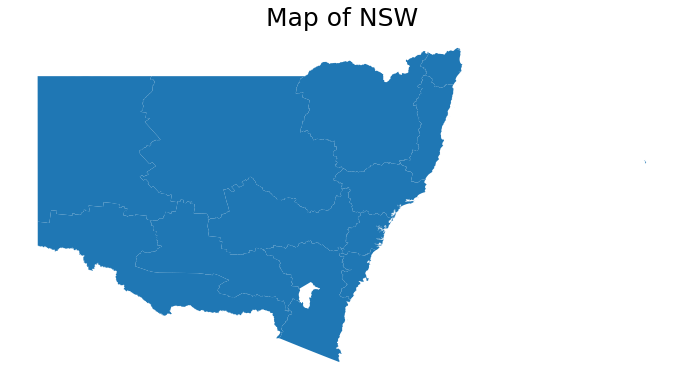

In [5]:
#Map showing NSW boundaries
import matplotlib.pyplot as plt
plt.tight_layout()
dpi=100
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 8))
map_nsw =nsw.plot(figsize=(15,10),ax=ax)

ax.set_title("Map of NSW" , fontdict={"fontsize": "25", "fontweight": "3"})
map_nsw.axis('off')

In [6]:
## loaded csv file containing population data for key regions in NSW.
nsw_raw = pd.read_csv("C:/Users/Eni/OneDrive/Data Analysis Challenge/NSW_Population_2018-19.csv")
nsw_pop=nsw_raw.copy()
nsw_pop.drop(["SA3 code","SA2 code","SA4 code"],axis=1,inplace=True)
nsw_pop.dtypes

SA4 name                 object
SA3name                  object
SA2 name                 object
pop_2018                  int64
pop_2019                  int64
Nat_inc                   int64
Net_int_mig               int64
Net_over_mig              int64
Area_km2                float64
Pdensity_persons_km2    float64
dtype: object

In [7]:
print(nsw_pop.shape)
nsw_pop.head(4)

(576, 10)


,SA4 name,SA3name,SA2 name,pop_2018,pop_2019,Nat_inc,Net_int_mig,Net_over_mig,Area_km2,Pdensity_persons_km2
0,Capital Region,Queanbeyan,Braidwood,4145,4222,9,58,10,3418.4,1.2
1,Capital Region,Queanbeyan,Karabar,8424,8372,89,-179,38,7.0,1199.0
2,Capital Region,Queanbeyan,Queanbeyan,11441,11451,80,-208,138,4.8,2404.0
3,Capital Region,Queanbeyan,Queanbeyan - East,5077,5150,62,-57,68,13.0,396.1


In [8]:
#creating new column "Region"

nsw_pop['Region']= ""
nsw_pop=nsw_pop[["SA4 name", "Region", "SA2 name", "pop_2018", "pop_2019", "Nat_inc", "Net_int_mig", "Net_over_mig", "Area_km2", "Pdensity_persons_km2"]]
nsw_pop.head()

,SA4 name,Region,SA2 name,pop_2018,pop_2019,Nat_inc,Net_int_mig,Net_over_mig,Area_km2,Pdensity_persons_km2
0,Capital Region,,Braidwood,4145,4222,9,58,10,3418.4,1.2
1,Capital Region,,Karabar,8424,8372,89,-179,38,7.0,1199.0
2,Capital Region,,Queanbeyan,11441,11451,80,-208,138,4.8,2404.0
3,Capital Region,,Queanbeyan - East,5077,5150,62,-57,68,13.0,396.1
4,Capital Region,,Queanbeyan Region,19151,20241,223,802,65,3054.4,6.6


In [9]:
#Populating Region column based on the SSD data from the ABS
nsw_pop.loc[276:576,"Region"] ="Sydney" # rows for Sydney
nsw_pop.loc[260:275,"Region"] ="Murrumbidgee" # rows for Murrumbidgee
#nsw_pop.loc[264:276,"Region"] ="Riverina" # rows for Riverina Murrumbidgee
nsw_pop.loc[238:259,"Region"] ="Richmond-Tweed" # rows for Richmond-Tweed
nsw_pop.loc[208:237,"Region"] ="Hunter" # rows for NewCastle and Lake Macquarie=Hunter!
nsw_pop.loc[188:207,"Region"] ="Northern" # rows for New England and North West=Northern
nsw_pop.loc[174:187,"Region"] ="Murray" # rows for Murray
nsw_pop.loc[153:174,"Region"] ="Mid-North Coast" # rows for Mid-North Coast
nsw_pop.loc[129:152,"Region"] ="Illawarra" # rows for Illawarra
nsw_pop.loc[106:128,"Region"] ="Hunter" # rows for Hunter
nsw_pop.loc[91:95,"Region"]="North Western" # rows for Far West and Orana
nsw_pop.loc[98:105,"Region"]="North Western" # rows for Far West and Orana
nsw_pop.loc[96:97,"Region"]="Far West" # rows for Far West and Orana= Broken Hill
nsw_pop.loc[79:90,"Region"]="Mid-North Coast" # rows for Coffs Harbour-Grafton=mid north coast
nsw_pop.loc[57:78,"Region"]="Central West" # rows for Central West
nsw_pop.loc[27:56,"Region"]="Sydney" # rows for Central Coast=Sydney
nsw_pop.loc[0:26,"Region"]="South Eastern" # rows for Capital Region=South Eastern

In [10]:
#nsw_pop.iloc[175:208]
nsw_pop.head(5)

,SA4 name,Region,SA2 name,pop_2018,pop_2019,Nat_inc,Net_int_mig,Net_over_mig,Area_km2,Pdensity_persons_km2
0,Capital Region,South Eastern,Braidwood,4145,4222,9,58,10,3418.4,1.2
1,Capital Region,South Eastern,Karabar,8424,8372,89,-179,38,7.0,1199.0
2,Capital Region,South Eastern,Queanbeyan,11441,11451,80,-208,138,4.8,2404.0
3,Capital Region,South Eastern,Queanbeyan - East,5077,5150,62,-57,68,13.0,396.1
4,Capital Region,South Eastern,Queanbeyan Region,19151,20241,223,802,65,3054.4,6.6


In [11]:
# grouping here to sum population data at the "Region" Level 
#as the geodataframe is at the region level already this is good to go!
nsw_pop_grp=nsw_pop.groupby(["Region"]).agg({"pop_2018":'sum',"pop_2019":'sum',"Nat_inc":'sum',"Net_int_mig":'sum',"Net_over_mig":'sum',"Area_km2":'sum',"Pdensity_persons_km2":'sum'}).reset_index()
nsw_pop_grp

,Region,pop_2018,pop_2019,Nat_inc,Net_int_mig,Net_over_mig,Area_km2,Pdensity_persons_km2
0,Central West,212412,213384,770,-354,556,70297.3,1383.9
1,Far West,20208,19928,20,-350,50,146860.2,102.7
2,Hunter,652347,659271,2284,1599,3041,22362.0,36515.9
3,Illawarra,310880,314618,1191,140,2407,1539.1,24585.9
4,Mid-North Coast,377887,381483,-346,2711,1231,32182.9,4693.6
5,Murray,103751,104109,92,-97,363,97696.1,1535.9
6,Murrumbidgee,160914,161595,806,-953,828,56984.9,1944.9
7,North Western,96972,97034,592,-836,306,192503.5,994.8
8,Northern,186661,187071,778,-1210,842,99145.9,939.3
9,Richmond-Tweed,250761,252650,142,636,1111,10271.0,6044.1


In [15]:
nsw_copy.describe()

,postcode,long,lat,sa3,sa4
count,5536.000000,5536.000000,5536.000000,5444.000000,5444.000000
mean,2442.445629,149.004274,-32.573990,13101.408339,130.987693
std,348.244679,14.799428,3.833170,10530.708098,105.304817
min,1001.000000,0.000000,-37.366176,10101.000000,101.000000
25%,2325.000000,149.462148,-34.164709,10604.000000,106.000000
50%,2472.000000,150.931838,-33.466271,11103.000000,111.000000
75%,2650.000000,151.658070,-31.505932,11703.000000,117.000000
max,4385.000000,159.081217,0.000000,90103.000000,901.000000


In [16]:
nsw_pop.describe()

,pop_2018,pop_2019,Nat_inc,Net_int_mig,Net_over_mig,Area_km2,Pdensity_persons_km2
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,13854.458333,14044.821181,79.092014,-38.303819,149.574653,1390.297569,1785.651562
std,7849.620170,8048.836797,109.483611,396.756545,238.386317,7587.343811,2437.163056
min,0.000000,0.000000,-211.000000,-2584.000000,0.000000,0.900000,0.000000
25%,7306.750000,7321.000000,7.000000,-132.750000,21.000000,5.975000,52.350000
50%,12775.500000,13001.500000,53.000000,-30.000000,61.000000,16.800000,732.450000
75%,19630.250000,19917.750000,129.500000,34.250000,174.250000,125.625000,2834.050000
max,40220.000000,42605.000000,766.000000,4435.000000,2633.000000,146690.100000,16750.700000


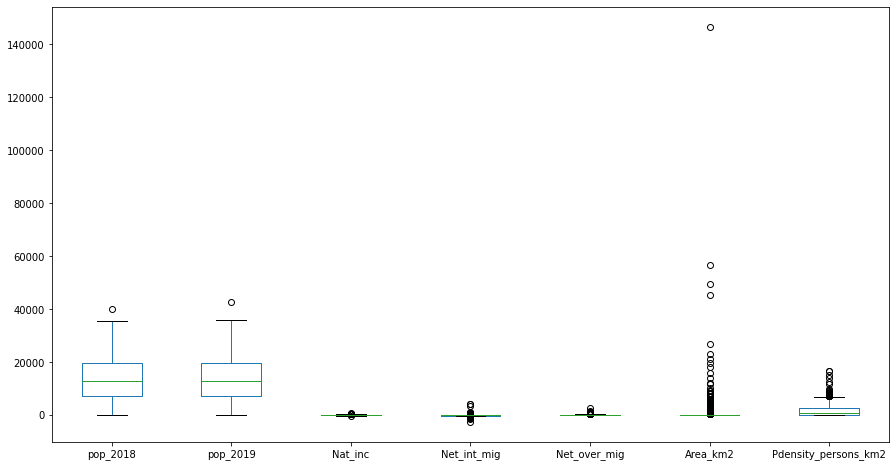

In [17]:
nsw_pop.plot.box(figsize=(15,8))

In [18]:
# join the geodataframe with the grouped up csv dataframe
merged = nsw.set_index("SD_NAME11").join(nsw_pop_grp.set_index("Region"))
merged.head(4)

,STATE_CODE,SD_CODE11,geometry,pop_2018,pop_2019,Nat_inc,Net_int_mig,Net_over_mig,Area_km2,Pdensity_persons_km2
SD_NAME11,,,,,,,,,,
Sydney,1,105,"MULTIPOLYGON (((151.27038 -33.84778, 151.27040...",5379640,5468764,38649,-24037,74512,19072.9,943454.9
Hunter,1,110,"MULTIPOLYGON (((152.31869 -32.62826, 152.31869...",652347,659271,2284,1599,3041,22362.0,36515.9
Illawarra,1,115,"MULTIPOLYGON (((150.35880 -35.58644, 150.35877...",310880,314618,1191,140,2407,1539.1,24585.9
Richmond-Tweed,1,120,"MULTIPOLYGON (((153.61835 -28.71141, 153.61832...",250761,252650,142,636,1111,10271.0,6044.1


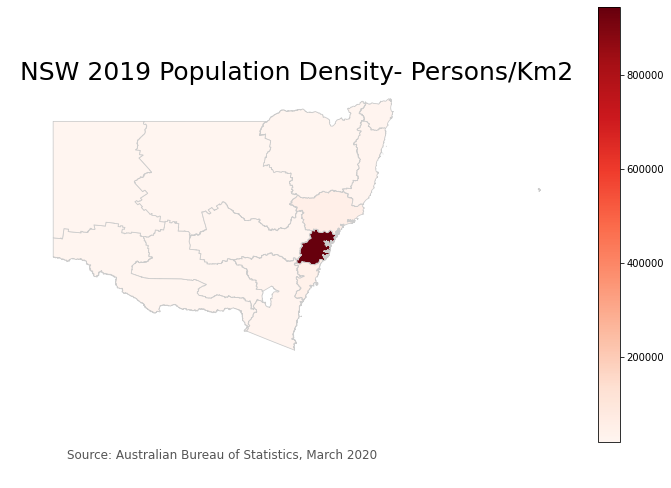

In [19]:
# set a variable that will call whatever column we want to visualise on the map
variable = "Pdensity_persons_km2"
# set the range for the choropleth
vmin, vmax = 20000, 945000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 8))
dpi=150
# create map
merged.plot(column=variable, cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8")
# remove the axis
ax.axis("off")
# add a title
ax.set_title("NSW 2019 Population Density- Persons/Km2" , fontdict={"fontsize": "25", "fontweight": "3"})
# create an annotation for the data source
ax.annotate("Source: Australian Bureau of Statistics, March 2020",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
#Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

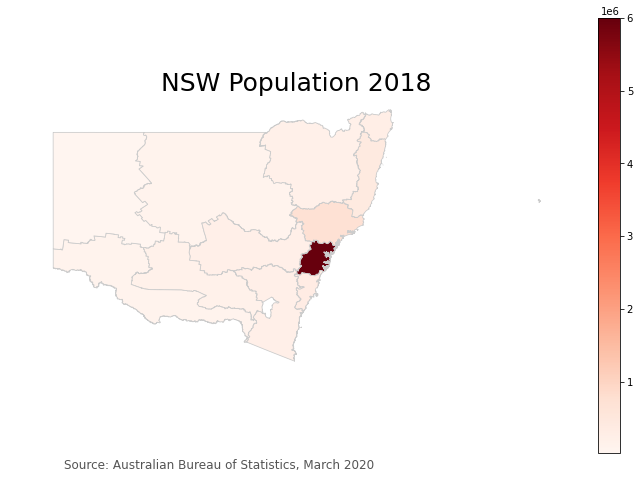

In [20]:
# set a variable that will call whatever column we want to visualise on the map
variable = "pop_2018"
# set the range for the choropleth
vmin, vmax = 20000, 6000000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 8))
dpi=150
# create map
merged.plot(column=variable, cmap="Reds", linewidth=0.8, ax=ax, edgecolor="0.8")
# remove the axis
ax.axis("off")
# add a title
ax.set_title("NSW Population 2018" , fontdict={"fontsize": "25", "fontweight": "3"})
# create an annotation for the data source
ax.annotate("Source: Australian Bureau of Statistics, March 2020",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
#Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

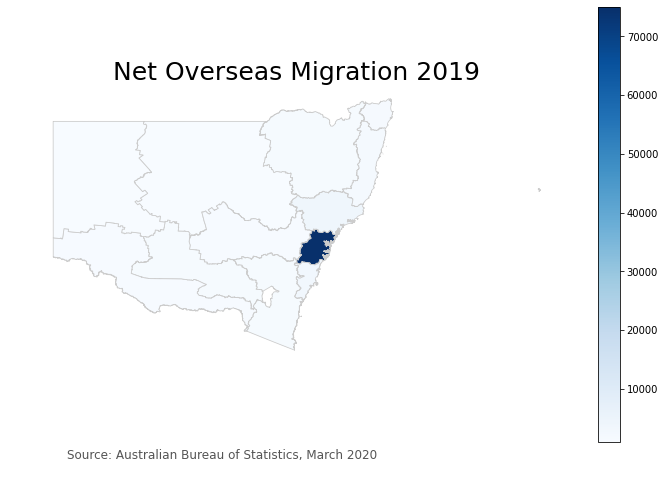

In [21]:
# set a variable that will call whatever column we want to visualise on the map
variable = "Net_over_mig"
# set the range for the choropleth
vmin, vmax = 1000, 75000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 8))
dpi=150
# create map
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
# remove the axis
ax.axis("off")
# add a title
ax.set_title("Net Overseas Migration 2019" , fontdict={"fontsize": "25", "fontweight": "3"})
# create an annotation for the data source
ax.annotate("Source: Australian Bureau of Statistics, March 2020",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
#Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

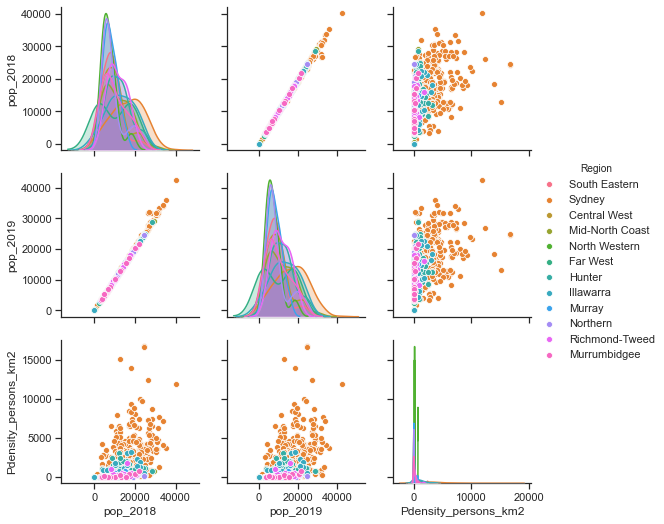

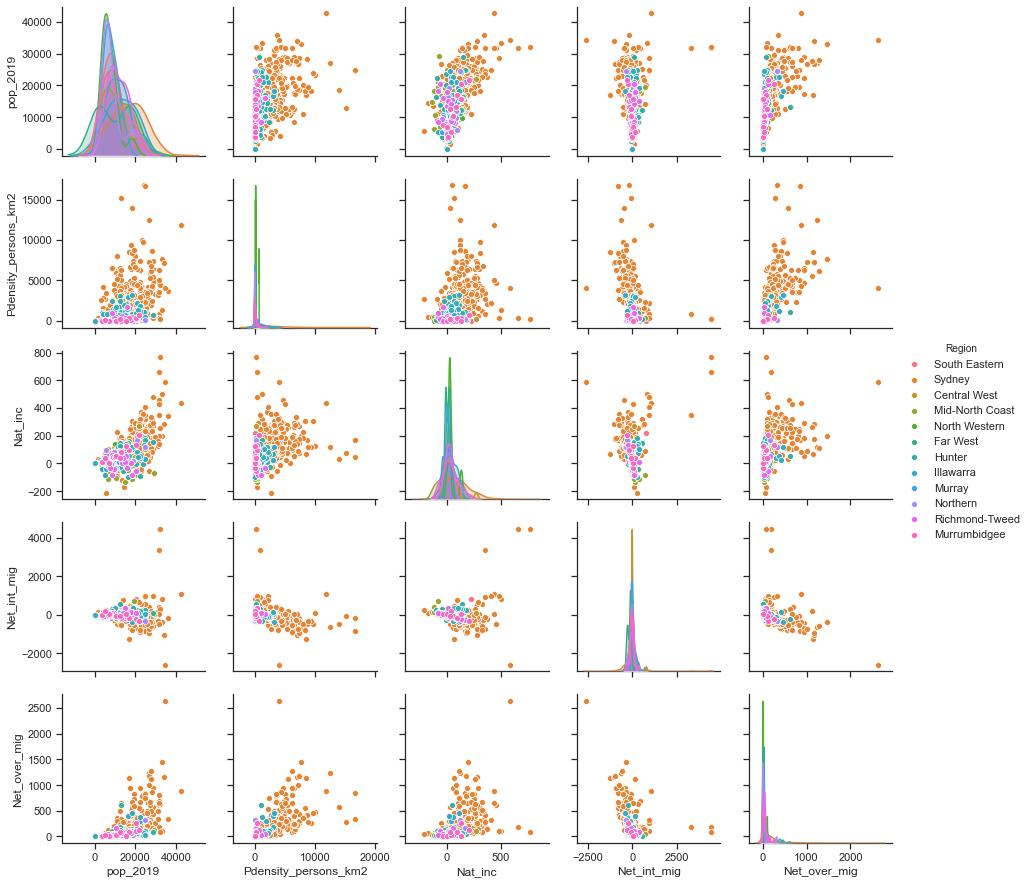

In [22]:
import seaborn as sns
sns.set(style="ticks")
#x = nsw_pop_grp[["pop_2018","pop_2019","Nat_inc","Net_int_mig","Net_over_mig","Area_km2","Pdensity_persons_km2"]]
#y =nsw_pop_grp["Region"]
x1 = nsw_pop[["pop_2018","pop_2019","Pdensity_persons_km2","Region"]]
x3 = nsw_pop[["pop_2019","Pdensity_persons_km2","Nat_inc","Net_int_mig","Net_over_mig","Region"]]
sns.pairplot(x1,hue="Region")
sns.pairplot(x3,hue="Region")

## Creating a new dataframe to be segmented and clustered neighborhoods affected by the fire in NSW.
##### Starting from September 2019, fires heavily impacted various regions of the state of New South Wales, such as the North Coast, Mid North Coast, the Hunter Region, the Hawkesbury and the Wollondilly in Sydney's far west, the Blue Mountains, Illawarra and the South Coast, Riverina and Snowy Mountains 

In [13]:
## This new group will be utilized for our future clustering.
nsw_fire = nsw_neigh[nsw_neigh['sa4name'].str.contains('Sydney|Riverina',regex=True)].reset_index(drop=True)
print(nsw_fire.shape)
nsw_fire.iloc[0:4]

(46, 7)


,sa3,locality,long,lat,sa3name,sa4,sa4name
0,11301.0,BYGALORIE,146.667476,-33.814887,Griffith - Murrumbidgee (West),113.0,Riverina
1,11302.0,BANGO,148.965503,-34.758330,Tumut - Tumbarumba,113.0,Riverina
2,11303.0,CULLINGA,148.255601,-34.599488,Wagga Wagga,113.0,Riverina
3,11501.0,CASTLE HILL,151.030535,-33.735906,Baulkham Hills,115.0,Sydney - Baulkham Hills and Hawkesbury


In [14]:
address = 'Sydney, Australia'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney are -33.8548157, 151.2164539.


let's visualize Sydney and the suburbs/regions in it.

In [15]:
# create map of Sydney using latitude and longitude values from the regions impacted by fire
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(nsw_fire['lat'], nsw_fire['long'], nsw_fire['sa4name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = '4Y1B1LY1GIYTHZC3ADW3TNTBO4ZI1KPL1NN4SR542LBVUIUX' # your Foursquare ID
CLIENT_SECRET = 'LDO0DUJ0O5VXK3JGAZKFKWDDMTBNR5P2RCMEDECZ5TKD0S2W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4Y1B1LY1GIYTHZC3ADW3TNTBO4ZI1KPL1NN4SR542LBVUIUX
CLIENT_SECRET:LDO0DUJ0O5VXK3JGAZKFKWDDMTBNR5P2RCMEDECZ5TKD0S2W


#### Let's explore the most popular neighborhood in NSW(indeed Australia!) in our dataframe.

In [17]:
nsw_fire.loc[11, 'sa3name']

'Sydney Inner City'

Get the neighborhood's latitude and longitude values.

In [18]:
neighborhood_latitude = nsw_fire.loc[11, 'lat'] # neighborhood latitude value
neighborhood_longitude = nsw_fire.loc[11, 'long'] # neighborhood longitude value

neighborhood_name = nsw_fire.loc[11, 'sa3name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Sydney Inner City are -33.794883, 151.268071.


#### Now, let's get the top 100 venues that are in Sydney within a radius of 5000 meters.

First, let's create the GET request URL. called **url**.

In [19]:
radius =5000 # australia is a big country and people tend to spread wider than 500m! using this will give<20!!
LIMIT =100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=4Y1B1LY1GIYTHZC3ADW3TNTBO4ZI1KPL1NN4SR542LBVUIUX&client_secret=LDO0DUJ0O5VXK3JGAZKFKWDDMTBNR5P2RCMEDECZ5TKD0S2W&ll=-33.794883,151.268071&v=20180605&radius=5000&limit=100'

Send the GET request and examine the results

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e95b494b1cac0001b73fa15'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 131,
  'suggestedBounds': {'ne': {'lat': -33.749882954999954,
    'lng': 151.32211935033686},
   'sw': {'lat': -33.83988304500004, 'lng': 151.21402264966312}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e73bf01d16472c0374f2ab9',
       'name': 'Roseberry Street Cafe',
       'location': {'address': '2/62 Balgowlah Rd',
        'lat': -33.790208,
        'lng': 151.26706,
        'labeledLatLngs': [{'label': 'display',
          'lat': -33.79020

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roseberry Street Cafe,Café,-33.790208,151.267060
1,Forty Baskets Beach,Beach,-33.802796,151.269834
2,Delwood Beach,Beach,-33.799439,151.277613
3,Fairlight Beach,Beach,-33.799728,151.274930
4,Spit to Manly,Trail,-33.798550,151.254959


And how many venues were returned by Foursquare?

In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## 2. Explore Neighborhoods in NSW Fire Dataframe

#### Let's create a function to repeat the same process to all the neighborhoods in NSW fire dataframe

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['sa3name', 
                  'lat', 
                  'long', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *nearby_venues*.

In [25]:
nearby_venues = getNearbyVenues(names=nsw_fire['sa3name'],
                                   latitudes=nsw_fire['lat'],
                                   longitudes=nsw_fire['long']
                                  )

Griffith - Murrumbidgee (West)
Tumut - Tumbarumba
Wagga Wagga
Baulkham Hills
Dural - Wisemans Ferry
Hawkesbury
Blacktown
Blacktown - North
Mount Druitt
Botany
Marrickville - Sydenham - Petersham
Sydney Inner City
Eastern Suburbs - North
Eastern Suburbs - South
Bankstown
Canterbury
Hurstville
Kogarah - Rockdale
Canada Bay
Leichhardt
Strathfield - Burwood - Ashfield
Chatswood - Lane Cove
Hornsby
Ku-ring-gai
North Sydney - Mosman
Manly
Pittwater
Warringah
Campbelltown (NSW)
Wollondilly
Blue Mountains
Blue Mountains - South
Penrith
Richmond - Windsor
St Marys
Auburn
Carlingford
Merrylands - Guildford
Parramatta
Pennant Hills - Epping
Ryde - Hunters Hill
Bringelly - Green Valley
Fairfield
Liverpool
Cronulla - Miranda - Caringbah
Sutherland - Menai - Heathcote


#### Let's check the size of the resulting dataframe

In [27]:
print(nearby_venues.shape)
nearby_venues.head(20)

(3423, 7)


,sa3name,lat,long,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tumut - Tumbarumba,-34.758330,148.965503,bakso kang eddy,-34.762485,148.956521,Indonesian Restaurant
1,Baulkham Hills,-33.735906,151.030535,JB HIFI,-33.729684,151.006786,Music Store
2,Baulkham Hills,-33.735906,151.030535,Myer,-33.729539,151.006931,Department Store
3,Baulkham Hills,-33.735906,151.030535,La Sante Medi Spa,-33.743130,151.045470,Spa
4,Baulkham Hills,-33.735906,151.030535,Pennant Hills Golf Course,-33.753726,151.048946,Golf Course
5,Baulkham Hills,-33.735906,151.030535,The Baron,-33.731644,151.006477,Coffee Shop
6,Baulkham Hills,-33.735906,151.030535,Crooked Tailor,-33.734470,151.003310,Bar
7,Baulkham Hills,-33.735906,151.030535,Cafe Saligna,-33.744913,151.037837,Café
8,Baulkham Hills,-33.735906,151.030535,Sedici,-33.721820,151.025530,Italian Restaurant
9,Baulkham Hills,-33.735906,151.030535,Harris Farm Markets,-33.737938,151.070712,Farmers Market


Let's check how many venues were returned for each neighborhood

In [28]:
nearby_venues.groupby('sa3name').count()

,lat,long,Venue,Venue Latitude,Venue Longitude,Venue Category
sa3name,,,,,,
Auburn,100,100,100,100,100,100
Bankstown,100,100,100,100,100,100
Baulkham Hills,100,100,100,100,100,100
Blacktown,100,100,100,100,100,100
Blacktown - North,100,100,100,100,100,100
Blue Mountains,5,5,5,5,5,5
Blue Mountains - South,19,19,19,19,19,19
Botany,100,100,100,100,100,100
Bringelly - Green Valley,12,12,12,12,12,12


Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 233 uniques categories.


## 3. Analyze Each Neighborhood

In [30]:
# one hot encoding
nsw_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nsw_onehot['sa3name'] = nearby_venues['sa3name'] 

# move neighborhood column to the first column
fixed_columns = [nsw_onehot.columns[-1]] + list(nsw_onehot.columns[:-1])
nsw_onehot = nsw_onehot[fixed_columns]

nsw_onehot.head()

,sa3name,Afghan Restaurant,Airport,Airport Lounge,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Tumut - Tumbarumba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baulkham Hills,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baulkham Hills,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Baulkham Hills,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baulkham Hills,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [31]:
nsw_onehot.shape

(3423, 234)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each categor

In [32]:
nsw_grouped = nsw_onehot.groupby('sa3name').mean().reset_index()
nsw_grouped

,sa3name,Afghan Restaurant,Airport,Airport Lounge,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Auburn,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.010000,...,0.00,0.020000,0.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
1,Bankstown,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.020000,0.000000,...,0.00,0.150000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
2,Baulkham Hills,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.01,0.00
3,Blacktown,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
4,Blacktown - North,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.010000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
5,Blue Mountains,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
6,Blue Mountains - South,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
7,Botany,0.00,0.01,0.02,0.00,0.01,0.00,0.00,0.010000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
8,Bringelly - Green Valley,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00
9,Campbelltown (NSW),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,...,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00


Let's confirm the new size

In [33]:
nsw_grouped.shape

(44, 234)

Let's print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 10

for hood in nsw_grouped['sa3name']:
    print("----"+hood+"----")
    temp = nsw_grouped[nsw_grouped['sa3name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Auburn----
                 venue  freq
0                 Café  0.09
1                 Park  0.08
2  Lebanese Restaurant  0.06
3          Supermarket  0.04
4    Indian Restaurant  0.04
5         Burger Joint  0.03
6  Japanese Restaurant  0.03
7         Dessert Shop  0.03
8      Thai Restaurant  0.03
9     Sushi Restaurant  0.02


----Bankstown----
                   venue  freq
0  Vietnamese Restaurant  0.15
1          Grocery Store  0.07
2                   Café  0.06
3   Fast Food Restaurant  0.06
4     Chinese Restaurant  0.05
5                    Gym  0.04
6         Sandwich Place  0.04
7                    Bar  0.03
8       Asian Restaurant  0.02
9     Italian Restaurant  0.02


----Baulkham Hills----
                  venue  freq
0                  Café  0.13
1         Grocery Store  0.05
2                   Gym  0.05
3           Supermarket  0.05
4       Thai Restaurant  0.05
5      Department Store  0.04
6          Burger Joint  0.04
7    Chinese Restaurant  0.04
8        S

             venue  freq
0             Café  0.12
1             Park  0.09
2              Bar  0.07
3   Ice Cream Shop  0.07
4      Coffee Shop  0.06
5  Thai Restaurant  0.05
6           Bakery  0.05
7          Brewery  0.03
8              Pub  0.03
9      Pizza Place  0.03


----Liverpool----
                   venue  freq
0                   Café  0.22
1                   Park  0.10
2      Korean Restaurant  0.04
3     Italian Restaurant  0.04
4            Coffee Shop  0.04
5     Chinese Restaurant  0.04
6                 Bakery  0.04
7       Greek Restaurant  0.02
8  Portuguese Restaurant  0.02
9            Pizza Place  0.02


----Manly----
                  venue  freq
0                  Café  0.15
1                  Park  0.12
2           Golf Course  0.08
3                   Pub  0.08
4                 Beach  0.08
5        Ice Cream Shop  0.04
6                 Trail  0.04
7                 Hotel  0.04
8     Fish & Chips Shop  0.04
9  Fast Food Restaurant  0.04


----Marrickville

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [47]:
#importing Numpy libraries first
import numpy as np
# create columns according to number of top venues
columns = ['sa3name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['sa3name'] = nsw_grouped['sa3name']

for ind in np.arange(nsw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nsw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(4)

,sa3name,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auburn,Café,Park,Lebanese Restaurant,Indian Restaurant,Supermarket,Japanese Restaurant,Burger Joint,Thai Restaurant,Dessert Shop,Ice Cream Shop
1,Bankstown,Vietnamese Restaurant,Grocery Store,Fast Food Restaurant,Café,Chinese Restaurant,Gym,Sandwich Place,Bar,Department Store,Pizza Place
2,Baulkham Hills,Café,Thai Restaurant,Grocery Store,Gym,Supermarket,Burger Joint,Department Store,Sandwich Place,Chinese Restaurant,Fast Food Restaurant
3,Blacktown,Café,Fast Food Restaurant,Shopping Mall,Thai Restaurant,Coffee Shop,Pizza Place,Convenience Store,Gym,Grocery Store,Sandwich Place


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [43]:
# set number of clusters
kclusters = 5

nsw_grouped_clustering = nsw_grouped.drop('sa3name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nsw_grouped_clustering)

# check cluster labels generated for each of the 44 rows in the dataframe
kmeans.labels_[0:44] 

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 4, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 3, 1, 1, 1, 0, 1, 2, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nsw_merged2 = nsw_fire

# merge nsw_grouped with nsw_copy to add latitude/longitude for each neighborhood
nsw_merged2 = nsw_merged2.join(neighborhoods_venues_sorted.set_index('sa3name'), on='sa3name')

nsw_merged2.head(13) # check the last columns before the ranking!

,sa3,locality,long,lat,sa3name,sa4,sa4name,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,11301.0,BYGALORIE,146.667476,-33.814887,Griffith - Murrumbidgee (West),113.0,Riverina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11302.0,BANGO,148.965503,-34.758330,Tumut - Tumbarumba,113.0,Riverina,2.0,Indonesian Restaurant,Zoo Exhibit,Electronics Store,Food,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
2,11303.0,CULLINGA,148.255601,-34.599488,Wagga Wagga,113.0,Riverina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11501.0,CASTLE HILL,151.030535,-33.735906,Baulkham Hills,115.0,Sydney - Baulkham Hills and Hawkesbury,0.0,Café,Thai Restaurant,Grocery Store,Gym,Supermarket,Burger Joint,Department Store,Sandwich Place,Chinese Restaurant,Fast Food Restaurant
4,11502.0,ANNANGROVE,150.974528,-33.656984,Dural - Wisemans Ferry,115.0,Sydney - Baulkham Hills and Hawkesbury,0.0,Garden,Stables,Supermarket,Golf Course,Fast Food Restaurant,Middle Eastern Restaurant,Indian Restaurant,Filipino Restaurant,Fish & Chips Shop,Electronics Store
5,11503.0,BUCKETTY,151.189243,-33.325373,Hawkesbury,115.0,Sydney - Baulkham Hills and Hawkesbury,4.0,Café,Shopping Mall,Golf Course,Chinese Restaurant,Zoo Exhibit,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
6,11601.0,SEVEN HILLS,150.966912,-33.760263,Blacktown,116.0,Sydney - Blacktown,0.0,Café,Fast Food Restaurant,Shopping Mall,Thai Restaurant,Coffee Shop,Pizza Place,Convenience Store,Gym,Grocery Store,Sandwich Place
7,11602.0,BEAUMONT HILLS,150.931074,-33.731523,Blacktown - North,116.0,Sydney - Blacktown,0.0,Café,Thai Restaurant,Coffee Shop,Sandwich Place,Supermarket,Pizza Place,Grocery Store,Gym,Burger Joint,Indian Restaurant
8,11603.0,COLEBEE,150.847460,-33.742006,Mount Druitt,116.0,Sydney - Blacktown,0.0,Fast Food Restaurant,Grocery Store,Convenience Store,Zoo Exhibit,Gym,Supermarket,Sandwich Place,Shopping Mall,Platform,Café
9,11701.0,BOTANY,151.197644,-33.947087,Botany,117.0,Sydney - City and Inner South,1.0,Café,Bakery,Coffee Shop,Park,Hotel,Gym / Fitness Center,Pizza Place,Italian Restaurant,Supermarket,Brewery


Finally, let's visualize the resulting clusters

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nsw_merged2['lat'], nsw_merged2['long'], nsw_merged2['sa3name'], nsw_merged2['Cluster Labels'].dropna().astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories.

#### Cluster 1

In [59]:
nsw_merged2.loc[nsw_merged2['Cluster Labels'] == 0, nsw_merged2.columns[[1] + list(range(4, nsw_merged2.shape[1]))]]

,locality,sa3name,sa4,sa4name,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,CASTLE HILL,Baulkham Hills,115.0,Sydney - Baulkham Hills and Hawkesbury,0.0,Café,Thai Restaurant,Grocery Store,Gym,Supermarket,Burger Joint,Department Store,Sandwich Place,Chinese Restaurant,Fast Food Restaurant
4,ANNANGROVE,Dural - Wisemans Ferry,115.0,Sydney - Baulkham Hills and Hawkesbury,0.0,Garden,Stables,Supermarket,Golf Course,Fast Food Restaurant,Middle Eastern Restaurant,Indian Restaurant,Filipino Restaurant,Fish & Chips Shop,Electronics Store
6,SEVEN HILLS,Blacktown,116.0,Sydney - Blacktown,0.0,Café,Fast Food Restaurant,Shopping Mall,Thai Restaurant,Coffee Shop,Pizza Place,Convenience Store,Gym,Grocery Store,Sandwich Place
7,BEAUMONT HILLS,Blacktown - North,116.0,Sydney - Blacktown,0.0,Café,Thai Restaurant,Coffee Shop,Sandwich Place,Supermarket,Pizza Place,Grocery Store,Gym,Burger Joint,Indian Restaurant
8,COLEBEE,Mount Druitt,116.0,Sydney - Blacktown,0.0,Fast Food Restaurant,Grocery Store,Convenience Store,Zoo Exhibit,Gym,Supermarket,Sandwich Place,Shopping Mall,Platform,Café
14,GEORGES HALL,Bankstown,119.0,Sydney - Inner South West,0.0,Vietnamese Restaurant,Grocery Store,Fast Food Restaurant,Café,Chinese Restaurant,Gym,Sandwich Place,Bar,Department Store,Pizza Place
15,BANKSTOWN,Canterbury,119.0,Sydney - Inner South West,0.0,Fast Food Restaurant,Grocery Store,Vietnamese Restaurant,Café,Sandwich Place,Lebanese Restaurant,Middle Eastern Restaurant,Gym,Convenience Store,Supermarket
16,BEVERLY HILLS,Hurstville,119.0,Sydney - Inner South West,0.0,Café,Grocery Store,Fast Food Restaurant,Supermarket,Middle Eastern Restaurant,Greek Restaurant,Pizza Place,Bakery,Lebanese Restaurant,Gym
17,KINGSGROVE,Kogarah - Rockdale,119.0,Sydney - Inner South West,0.0,Café,Lebanese Restaurant,Fast Food Restaurant,Supermarket,Chinese Restaurant,Coffee Shop,Park,Greek Restaurant,Gym,Bakery
26,MONA VALE,Pittwater,122.0,Sydney - Northern Beaches,0.0,Café,Flower Shop,Golf Course,Pub,Shopping Mall,Grocery Store,Trail,Garden Center,Electronics Store,Stadium


#### Cluster 2

In [58]:
nsw_merged2.loc[nsw_merged2['Cluster Labels'] == 1, nsw_merged2.columns[[1] + list(range(4, nsw_merged2.shape[1]))]]

,locality,sa3name,sa4,sa4name,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,BOTANY,Botany,117.0,Sydney - City and Inner South,1.0,Café,Bakery,Coffee Shop,Park,Hotel,Gym / Fitness Center,Pizza Place,Italian Restaurant,Supermarket,Brewery
10,MASCOT,Marrickville - Sydenham - Petersham,117.0,Sydney - City and Inner South,1.0,Café,Park,Bakery,Coffee Shop,Bar,Ice Cream Shop,Italian Restaurant,Vietnamese Restaurant,Pub,Supermarket
11,SYDNEY,Sydney Inner City,117.0,Sydney - City and Inner South,1.0,Café,Beach,Bakery,Park,Bar,Seafood Restaurant,Wine Bar,Pub,Scenic Lookout,Australian Restaurant
12,WOOLLAHRA,Eastern Suburbs - North,118.0,Sydney - Eastern Suburbs,1.0,Café,Park,Beach,Coffee Shop,Bakery,Australian Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Pizza Place,Pub
13,KENSINGTON,Eastern Suburbs - South,118.0,Sydney - Eastern Suburbs,1.0,Café,Ice Cream Shop,Park,Coffee Shop,Brewery,Bakery,Pub,Italian Restaurant,Bar,Pizza Place
18,DRUMMOYNE,Canada Bay,120.0,Sydney - Inner West,1.0,Café,Park,Italian Restaurant,Pizza Place,Coffee Shop,Trail,Liquor Store,Bar,Bakery,Fruit & Vegetable Store
19,ANNANDALE,Leichhardt,120.0,Sydney - Inner West,1.0,Café,Park,Ice Cream Shop,Bar,Coffee Shop,Thai Restaurant,Bakery,Pizza Place,Pub,Restaurant
20,MARRICKVILLE,Strathfield - Burwood - Ashfield,120.0,Sydney - Inner West,1.0,Café,Bar,Brewery,Bakery,Coffee Shop,Pub,Ice Cream Shop,Park,Pizza Place,Vietnamese Restaurant
21,NORTHBRIDGE,Chatswood - Lane Cove,121.0,Sydney - North Sydney and Hornsby,1.0,Café,Park,Japanese Restaurant,Beach,Coffee Shop,Italian Restaurant,Cocktail Bar,Scenic Lookout,Bakery,Fruit & Vegetable Store
22,HORNSBY,Hornsby,121.0,Sydney - North Sydney and Hornsby,1.0,Café,Pizza Place,Grocery Store,Thai Restaurant,Fast Food Restaurant,Park,Chinese Restaurant,Gym,Bakery,Italian Restaurant


#### Cluster 3

In [57]:
nsw_merged2.loc[nsw_merged2['Cluster Labels'] == 2, nsw_merged2.columns[[1] + list(range(4, nsw_merged2.shape[1]))]]

,locality,sa3name,sa4,sa4name,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,BANGO,Tumut - Tumbarumba,113.0,Riverina,2.0,Indonesian Restaurant,Zoo Exhibit,Electronics Store,Food,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


#### Cluster 4

In [56]:
nsw_merged2.loc[nsw_merged2['Cluster Labels'] == 3, nsw_merged2.columns[[1] + list(range(4, nsw_merged2.shape[1]))]]

,locality,sa3name,sa4,sa4name,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,AGNES BANKS,Richmond - Windsor,124.0,Sydney - Outer West and Blue Mountains,3.0,Mountain,Nature Preserve,Rock Climbing Spot,Campground,Event Space,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant


#### Cluster 5

In [55]:
nsw_merged2.loc[nsw_merged2['Cluster Labels'] == 4, nsw_merged2.columns[[1] + list(range(4, nsw_merged2.shape[1]))]]

,locality,sa3name,sa4,sa4name,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,BUCKETTY,Hawkesbury,115.0,Sydney - Baulkham Hills and Hawkesbury,4.0,Café,Shopping Mall,Golf Course,Chinese Restaurant,Zoo Exhibit,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
